# Error-related Potential Template Detection (Exploration)
Use this notebook to create template waveforms for error-related potentials (ErrPs) in a single subject, and use that template to run single-trial error detection via a template projection technique (2019.01.14-15).

In [1]:
from matplotlib import pyplot as plt
import scipy.signal as scisig
import numpy as np
import pandas as pd
import csv
import mne

## Variables to Set
Note, you will need to manually pick out which IC to reject for ICA later

In [2]:
subjID = 'nile'
filename_eeg = 'data/nile/20190130120351_nile_Error_Screening.easy'
filename_behavioral = 'data/nile/Error_Screening_nile_R1.csv'

## Load the EEG data
Load in the data from the NIC2 .easy file and convert to a Pandas dataframe

In [3]:
def ConvertEasyToDataFrame(filename):
    """ This function converts a single .easy file (from NIC2) to an easy-to-use dataframe.
    Uses both the .easy file and .info file (containing metadata)
    
    ---- Input ----
    filename: string containing the .easy filepath
    
    ---- Output ----
    df: dataframe containing all the EEG, accelerometer, and event marker data
    fs: sampling rate for the EEG data (Hz)
    fs_accel: sampling rate for the accelerometer data (Hz)
    
    """
    import pandas as pd
    
    # Read in the .easy file
    df = pd.read_csv(filename, delimiter='\t', header=None)
    
    # Get metadata from the .info file
    fname = filename[:-5] + '.info'
    with open(fname) as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    
    # Get the channel names
    channel_info = [x for x in content if 'Channel ' in x]
    channel_names = []
    for ch in range(len(channel_info)):
        channel_names.append(channel_info[ch].split(': ')[1])
        
    channel_names.append('X')
    channel_names.append('Y')
    channel_names.append('Z')
    channel_names.append('STI 014')
    channel_names.append('DateTime')
    
    # Get sampling rates
    sampling_rates = [x for x in content if 'sampling rate: ' in x]
    fs_all = []
    for freq in range(len(sampling_rates)):
            tmp = sampling_rates[freq].split(': ')[1].split(' ')[0]
            if tmp in ['N/A']:
                print('Skipping N/A')
            else:
                fs_all.append(float(sampling_rates[freq].split(': ')[1].split(' ')[0]))

    # Store sampling rates
    fs = fs_all[0]
    fs_accel = fs_all[1]
    
    # Assign the column names
    df.columns = channel_names
    
    # Return dataframe and sampling rates
    return df, fs, fs_accel

Load in data from the **error** screening task (not motor)

In [4]:
EEGdata, fs, fs_accel = ConvertEasyToDataFrame(filename_eeg)
EEGdata.head()

Skipping N/A


,F3,Fz,F4,FC1,C3,Cz,C4,Pz,X,Y,Z,STI 014,DateTime
0,26960471,70787104,59006459,71873864,20011951,86174164,76258382,49782520,0,0,0,0,1548878631062
1,26952889,70784434,59005935,71872481,20001986,86172304,76258048,49778610,-343,9522,147,0,1548878631064
2,26953557,70790537,59014184,71879586,20002033,86180744,76267060,49781519,-343,9522,147,0,1548878631066
3,26955607,70796259,59021384,71885594,20003035,86185608,76275262,49784141,-343,9522,147,0,1548878631068
4,26954797,70796355,59021670,71885117,20001509,86182556,76274070,49781519,-343,9522,147,0,1548878631070


In [5]:
# Check shape of the data
np.shape(EEGdata)

(348265, 13)

## Load the behavioral data
Make sure the behavioral data corresponds with the EEG data

In [6]:
behavioralData = pd.read_csv(filename_behavioral, ',')
behavioralHeader = behavioralData.columns
behavioralData.head()

,Unnamed: 0,time,player_x,player_y,target_x,target_y,key_pressed,direction_moved,error_induced,score
0,0,1.690742,570.5,190.5,114.5,191.0,left,left,False,0
1,1,2.295339,494.5,190.5,114.5,191.0,left,left,False,0
2,2,2.873942,418.5,190.5,114.5,191.0,left,left,False,0
3,3,3.431746,342.5,190.5,114.5,191.0,left,left,False,0
4,4,3.959348,266.5,190.5,114.5,191.0,left,left,False,0


### Sync up event markers / trigger pulses
Note that for the DSI-7, we sound audio beeps that are sent as pulses through the trigger hub and are recorded with the EEG. For the Enobio, we use Lab Streaming Layer (LSL) to send direct pulses with integer values to the recording software.

In [7]:
np.unique(EEGdata['STI 014'])

array([  0,  14,  21,  27,  29,  30,  32,  33,  35,  46,  48,  52,  54,
        58,  62,  68,  69,  75,  76,  77,  84,  96,  99, 100, 102, 105,
       119, 128, 131, 132, 140, 147, 148, 151, 154, 159, 168, 171, 172,
       176, 181, 185, 192, 193, 197, 198, 206, 214, 225, 228, 230, 231,
       236, 243, 244, 245, 257, 260, 261, 265, 266, 269, 273, 279, 280,
       281, 283, 284, 286, 287, 290, 291, 295, 296, 303, 315, 321, 326,
       327, 328, 332, 335, 341, 348, 354, 363, 371, 372, 374, 381, 397,
       399, 400, 407, 414, 420, 425, 427, 444, 445, 450, 453, 454, 459,
       461, 467, 472, 478, 493, 499, 502, 506, 514, 516, 522, 525, 527,
       533, 539, 540, 542, 543, 545, 546, 554, 557, 558, 559, 563, 566,
       568, 575, 581, 596, 599, 602, 605, 608, 609, 611, 615, 622, 624,
       625, 634, 635, 636, 642, 644, 648, 651, 662, 673, 679, 682, 683,
       685, 693, 694, 699, 706, 709, 710, 723, 724, 728, 736, 738, 739,
       746, 754], dtype=int64)

In [8]:
# Ignore the first error if the first movement was error
# because the pulse value would be 0 and we wouldn't able to log that in index_trigger
behavioral_error_trials = np.where(behavioralData['error_induced']==True)[0]

# Only store info for trials that are confirmed to be error movement
# From both the EEG data and from the behavioral data
error_trials = np.intersect1d(np.unique(EEGdata['STI 014'])[1:], behavioral_error_trials)

Note that in the error screening task, subjects have to press the arrow key 3 times before the cursor will actually move. This is why we see three pulses of the same value. The cursor does not move until the third pulse is sent.

In [9]:
index_trigger = list()

# Start from 1 and not 0 because 0 is used for no pulse sent as well
for i in range(0,len(error_trials)):
    index_trigger.append(np.where(EEGdata['STI 014'] == error_trials[i])[0][-1])

In [10]:
print(index_trigger)

[14011, 15861, 19003, 19586, 19914, 20563, 20828, 22628, 27005, 27563, 28746, 31795, 32905, 36033, 36313, 37979, 39308, 39706, 41637, 47106, 47970, 48297, 48938, 49905, 56338, 60130, 62280, 62609, 64930, 68330, 68594, 69531, 71722, 73206, 77123, 78089, 78434, 80931, 82345, 83609, 86832, 87146, 88346, 88657, 92394, 95802, 101162, 102066, 102643, 102974, 105683, 107683, 107985, 108266, 114577, 115475, 115778, 117975, 118242, 119122, 120325, 123609, 123992, 124297, 124992, 125353, 126042, 127961, 128945, 129297, 130609, 130906, 134298, 140313, 142177, 144985, 145310, 145626, 146860, 149035, 150897, 154097, 157177, 161411, 163769, 164102, 166057, 168265, 176026, 176736, 177041, 180330, 183474, 186554, 188265, 189041, 198188, 198625, 200481, 202609, 202986, 204730, 205463, 208745, 211872, 214099, 221393, 224664, 225674, 227989, 230748, 234553, 236965, 237740, 240735, 242841, 243169, 243865, 244201, 246153, 246557, 250562, 251532, 251825, 252132, 253329, 255932, 259691, 261583, 268692, 26966

In [11]:
np.shape(index_trigger)

(165,)

In [12]:
# Check number of trials
num_of_trials = behavioralData.shape[0]

In [13]:
num_of_error = len(index_trigger)
num_of_correct = num_of_trials - num_of_error - 1 # skipped the initial error movement because it had pulseValue 0

## Getting movement start times
I should have made the code such that it would send a pulse with a specific value for moving correctly and another value for moving incorrectly, but alas...

Because we don't have that information here, we will need to use the information from the behavioral data to figure out the start times. We need to figure out how much of a time difference there is between the time values recorded in the behavioral data (.csv) and between the timing of the pulses received in the EEG.

Every entry in the .csv is a movement. Every 3rd pulse (final pulse in series of three with same value) in the EEG correspond to entries in the .csv where the "error_induced" value is TRUE.

In [14]:
print('Time of second error in behavioral: ' + str(behavioralData['time'][behavioral_error_trials[0]]))
print('Time of second error in EEG: ' + str(index_trigger[0]/fs))

Time of second error in behavioral: 14.874611710838508
Time of second error in EEG: 28.022


In [15]:
t_diff_all = list()
for i in range(0, len(index_trigger)):
    t_diff_all.append((index_trigger[i]/fs)-behavioralData['time'][error_trials[i]])

print(t_diff_all)

[13.14738828916149, 13.146688835395501, 13.14737341891183, 13.146810481537123, 13.148013783173642, 13.147857350773638, 13.147405001492238, 13.14639510191651, 13.147978178856427, 13.147524829673571, 13.147626841762566, 13.146430735916361, 13.146705230467497, 13.146689009744676, 13.146707671763366, 13.147352924120604, 13.147738839694298, 13.147859968292067, 13.14623351240391, 13.146821222384943, 13.147742687081916, 13.146075497631443, 13.147426742896442, 13.146490506248071, 13.146389388268801, 13.146988267651778, 13.146620129179212, 13.146970798442595, 13.146346135486382, 13.146170924210452, 13.147535843227047, 13.147491319710852, 13.146391276718106, 13.147530693549669, 13.147394269894818, 13.14643646437628, 13.147838089598338, 13.146666370484013, 13.147082514418315, 13.147097870655784, 13.147774638792953, 13.147383920483293, 13.147273358325947, 13.146276253204292, 13.147454405668668, 13.146803862655986, 13.146957777709218, 13.147716608555527, 13.146285940347184, 13.146923688964023, 13.1

To find times in EEG for all trials, add the value of t_0 to the respective behavioral data time.

In [16]:
t_0 = np.mean(t_diff_all)
t_0

13.14701187121861

In [17]:
t_trial_start = list()

for i in range(0, num_of_trials):
    t_trial_start.append(behavioralData['time'][i] + t_0)

t_trial_start

[14.837754242007549,
 15.442350453757143,
 16.020953438362966,
 16.578758316640204,
 17.1063603524253,
 17.58837545826279,
 21.25471578736503,
 21.730252992130744,
 22.18932692310952,
 22.68311986216756,
 23.13962637767142,
 23.622219801241926,
 24.12141748389874,
 27.52394566469772,
 28.021623582057117,
 28.61230306601098,
 29.12409295718132,
 29.621680903715937,
 30.13348517165465,
 30.638658495388853,
 31.156367448043937,
 31.72232303582311,
 32.2754930241517,
 32.805275693537595,
 36.388832176222394,
 36.86763569381034,
 37.339694180411215,
 38.00563845230678,
 38.55556624371272,
 39.17220138968148,
 39.826998088044974,
 40.439189416125345,
 41.125154520444966,
 41.65560686972637,
 42.29082424211262,
 45.2566167693021,
 45.9240627195704,
 46.4728143972479,
 46.9949968488672,
 47.48947430838777,
 48.022744971271074,
 48.51485721778769,
 51.68967985001106,
 52.22641717316762,
 52.78978308459225,
 53.31570952927174,
 54.00903369236218,
 54.58990820899087,
 55.125487041545036,
 55.7234

In [18]:
# Get a nice list of whether a trial is error or not
isError = list()
correct_trials = list()
for i in range(0, len(behavioralData['error_induced'])):
    if behavioralData['error_induced'][i] == True:
        isError.append(1)
    else:
        isError.append(0)
        correct_trials.append(i)

correct_trials = np.asarray(correct_trials)

## Cleaning the EEG data

Common Average Reference

In [19]:
channels = EEGdata.columns[0:8]
tmp = EEGdata[channels].values

np.shape(tmp)

(348265, 8)

In [20]:
tmp2 = tmp
for i in range(0,len(tmp)):
    avg_val = np.mean(tmp[i,:])
    tmp2[i,:] = tmp[i,:] - avg_val

In [21]:
EEGdata[channels] = tmp2

Artifact removal and filtering

In [22]:
from mne.filter import filter_data

In [23]:
EEGdata_filt = EEGdata.copy()
channels = EEGdata.columns[0:8]

eeg_data = EEGdata[channels].values * 1.0 # multiply by 1.0 to convert int to float
filtered = filter_data(eeg_data.T, sfreq=fs, l_freq=1, h_freq=10)
EEGdata_filt[channels] = filtered.T

Setting up band-pass filter from 1 - 10 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 2.5 Hz
Filter length of 1651 samples (3.302 sec) selected


In [24]:
# Create the time array
time = np.linspace(0, np.shape(EEGdata)[0]/fs, np.shape(EEGdata)[0])

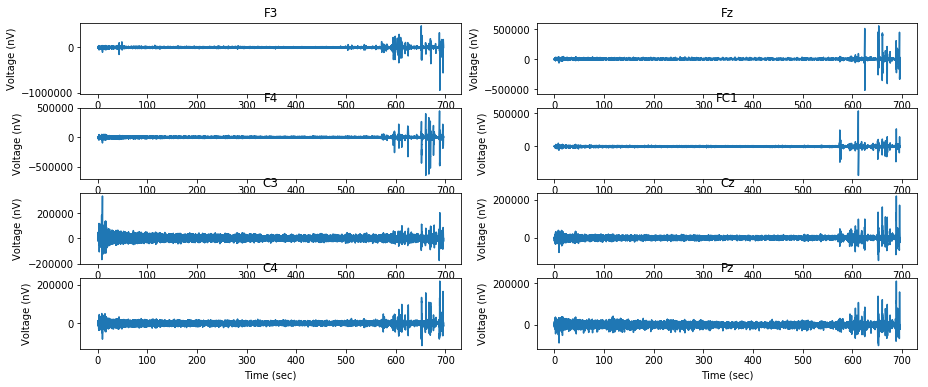

In [25]:
fig, axs = plt.subplots(4,2, figsize=(15, 6), facecolor='w', edgecolor='k')
axs = axs.ravel()
i = 0
channels = EEGdata.columns[0:8]

for chanOfInt in channels:
    axs[i].plot(time, EEGdata_filt[chanOfInt])
    axs[i].set_xlabel('Time (sec)')
    axs[i].set_ylabel('Voltage (nV)')
    axs[i].set_title(chanOfInt)
    i += 1

## Independent Component Analysis (ICA)
First, make a copy of our data and format it such that it can be used with MNE python. Follow tutorial from here https://martinos.org/mne/stable/auto_tutorials/plot_artifacts_correction_ica.html

But this page was more useful https://cbrnr.github.io/2018/01/29/removing-eog-ica/

In [26]:
ch_types = ['eeg']*len(channels)
info = mne.create_info(ch_names=list(channels), sfreq=fs, ch_types=ch_types)

rawData = EEGdata[channels].values
rawData = np.transpose(rawData)

raw = mne.io.array.RawArray(rawData, info)

Creating RawArray with float64 data, n_channels=8, n_times=348265
    Range : 0 ... 348264 =      0.000 ...   696.528 secs
Ready.


In [27]:
raw.filter(l_freq=1, h_freq=10)

Setting up band-pass filter from 1 - 10 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 2.5 Hz
Filter length of 1651 samples (3.302 sec) selected


<RawArray  |  None, n_channels x n_times : 8 x 348265 (696.5 sec), ~21.3 MB, data loaded>

<IPython.core.display.Javascript object>


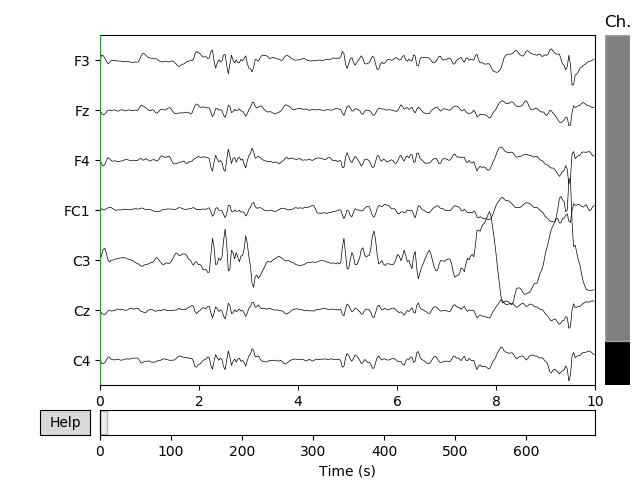

In [28]:
%matplotlib notebook
fig = raw.plot(n_channels=7, scalings='auto')

### Now run ICA

In [29]:
raw.set_montage(mne.channels.read_montage(kind='standard_1020'))

<RawArray  |  None, n_channels x n_times : 8 x 348265 (696.5 sec), ~21.3 MB, data loaded>

In [30]:
n_components = 7
method = 'fastica'
random_state = 23
ica = mne.preprocessing.ICA(n_components=n_components, method=method, random_state=random_state)

In [31]:
reject = dict(mag=5e-12, grad=4000e-13)
ica.fit(raw, reject=reject)
print(ica)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 7 components
Fitting ICA took 3.4s.
<ICA  |  raw data decomposition, fit (fastica): 348000 samples, 7 components, channels used: "eeg">


<IPython.core.display.Javascript object>


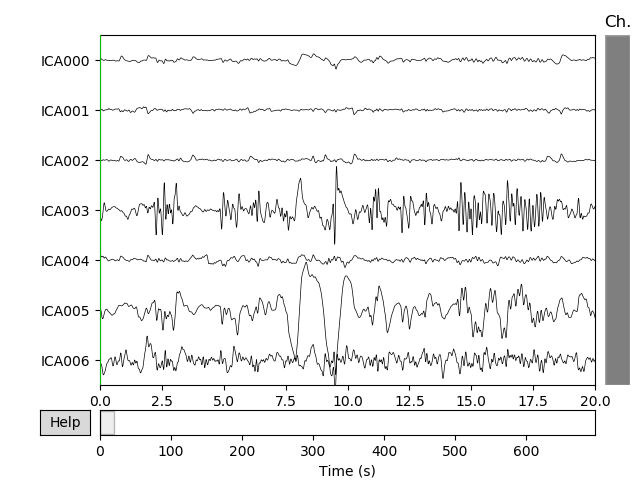

In [32]:
%matplotlib notebook
fig = ica.plot_sources(raw)

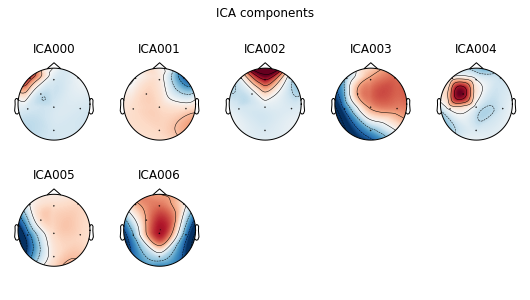

[<Figure size 540x288 with 10 Axes>]

In [33]:
%matplotlib inline
ica.plot_components()

    using multitaper spectrum estimation with 7 DPSS windows


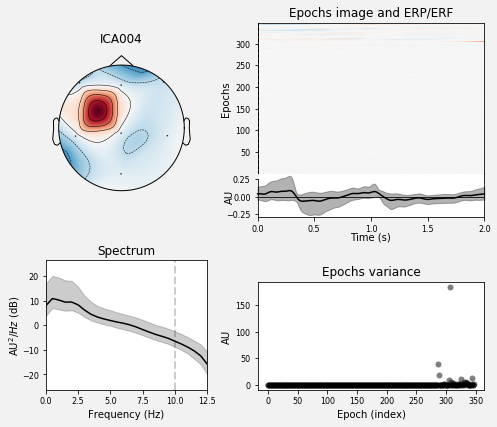

[<Figure size 504x432 with 5 Axes>]

In [34]:
# Take a closer look at an individual component
%matplotlib inline
ica.plot_properties(raw, picks=[4])

### Remove artifacts
Find likely artifacts, remove from signal, and reconstruct signal, then reassign to the dataframe format (to work with in the rest of the code)

In [35]:
ica.exclude = [] # most likely to be blinks (when you check source you can see clearly)

In [36]:
raw_corrected = raw.copy()
ica.apply(raw_corrected)

Transforming to ICA space (7 components)
Zeroing out 0 ICA components


<RawArray  |  None, n_channels x n_times : 8 x 348265 (696.5 sec), ~21.3 MB, data loaded>

<IPython.core.display.Javascript object>


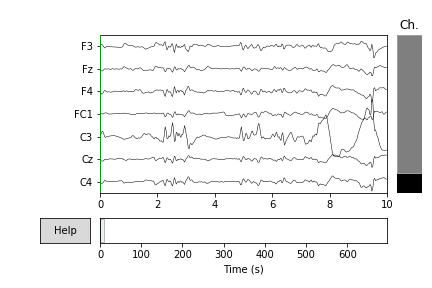

<IPython.core.display.Javascript object>


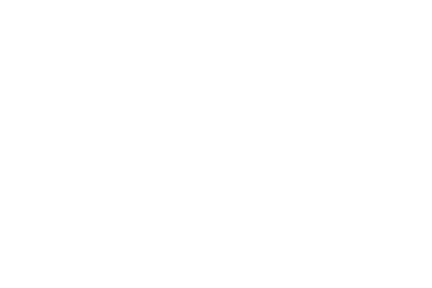

In [37]:
# Plot original
%matplotlib notebook
fig = raw.plot(n_channels = 7, scalings='auto')

<IPython.core.display.Javascript object>


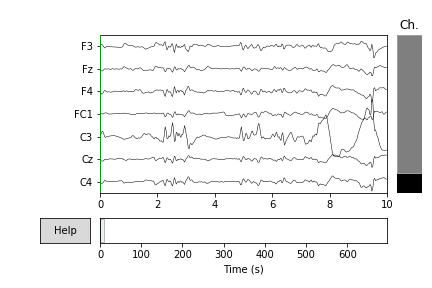

<IPython.core.display.Javascript object>


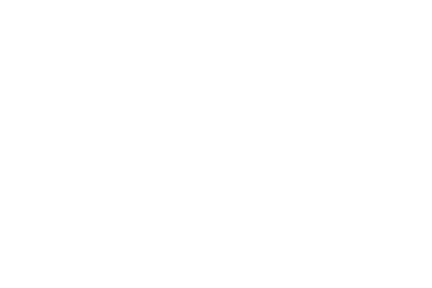

In [38]:
# Plot corrected
fig = raw_corrected.plot(n_channels = 7, scalings='auto')

Reassign this correct data to EEGdata

In [39]:
# Make a copy of the original data just in case
EEGdata_orig = EEGdata.copy()
EEGdata[channels] = raw_corrected.get_data().T
EEGdata_orig.head()

,F3,Fz,F4,FC1,C3,Cz,C4,Pz,X,Y,Z,STI 014,DateTime
0,-30646393,13180239,1399594,14266999,-37594913,28567299,18651517,-7824344,0,0,0,0,1548878631062
1,-30650446,13181098,1402599,14269145,-37601349,28568968,18654712,-7824725,-343,9522,147,0,1548878631064
2,-30655095,13181884,1405531,14270933,-37606619,28572091,18658407,-7827133,-343,9522,147,0,1548878631066
3,-30657754,13182897,1408022,14272232,-37610326,28572246,18661900,-7829220,-343,9522,147,0,1548878631068
4,-30657402,13184155,1409470,14272917,-37610690,28570356,18661870,-7830680,-343,9522,147,0,1548878631070


In [40]:
EEGdata.head()

,F3,Fz,F4,FC1,C3,Cz,C4,Pz,X,Y,Z,STI 014,DateTime
0,-6.910012e-11,-2.091701e-10,-1.978529e-14,5.089518e-11,-9.385671e-10,8.894971e-10,-4.001624e-10,5.457772e-11,0,0,0,0,1548878631062
1,1.453265e+03,-1.018944e+03,-1.124857e+03,5.197097e+02,1.266918e+03,-1.072445e+03,-9.598324e+02,9.362670e+02,-343,9522,147,0,1548878631064
2,2.896340e+03,-2.033929e+03,-2.245884e+03,1.033593e+03,2.534272e+03,-2.138657e+03,-1.913629e+03,1.868057e+03,-343,9522,147,0,1548878631066
3,4.319750e+03,-3.041329e+03,-3.359897e+03,1.535735e+03,3.803236e+03,-3.192270e+03,-2.856120e+03,2.791136e+03,-343,9522,147,0,1548878631068
4,5.714459e+03,-4.037647e+03,-4.464207e+03,2.020405e+03,5.075482e+03,-4.227217e+03,-3.782577e+03,3.701620e+03,-343,9522,147,0,1548878631070


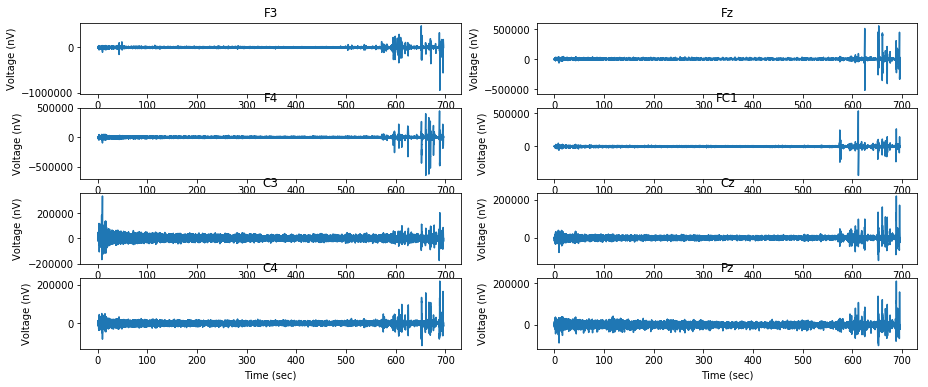

In [41]:
%matplotlib inline
fig, axs = plt.subplots(4,2, figsize=(15, 6), facecolor='w', edgecolor='k')
axs = axs.ravel()
i = 0
channels = EEGdata.columns[0:8]

for chanOfInt in channels:
    axs[i].plot(time, EEGdata[chanOfInt])
    axs[i].set_xlabel('Time (sec)')
    axs[i].set_ylabel('Voltage (nV)')
    axs[i].set_title(chanOfInt)
    i += 1

## Epoch the data
Separate the data by trials (cleaned "raw" data and frequency information) and visually inspect the time-frequency information for the trial conditions. Does power in any particular band look consistently different for math vs non-math trials?

In [42]:
epochs = []
epochs_filt = [] # pre-ICA filtered data

for trial in range(0,len(t_trial_start)):
    t_start = np.round((t_trial_start[trial] - 0 ) * fs)
    t_end = np.round((t_trial_start[trial] + 0.600) * fs)
    epochs.append(EEGdata.loc[t_start:t_end][channels])
    epochs_filt.append(EEGdata_filt.loc[t_start:t_end][channels])
    
    """    
    t_trial_end = t_trial_start[trial] + (0.600 * fs)
    epochs_raw.append(EEGdata.loc[t_trial_start[trial]:t_trial_end][channels])
    epochs_filt.append(EEGdata_filt.loc[t_trial_start[trial]:t_trial_end][channels])
    """

In [43]:
# This ends up returning a list of dataframes where df[trial number][channels]
epochs[0].head()

,F3,Fz,F4,FC1,C3,Cz,C4,Pz
7419,34721.516293,-21732.431651,-30114.429609,-22284.989781,50373.459768,-23062.279357,-23903.548980,36002.153720
7420,33392.862444,-21665.789645,-29227.716912,-22651.367913,51333.263930,-22925.365056,-23377.685089,35121.279813
7421,31907.079841,-21490.390624,-28164.361255,-22890.825558,51898.863297,-22640.717895,-22704.044743,34083.914988
7422,30269.515037,-21206.619586,-26929.237445,-22999.224279,52064.709985,-22208.868469,-21884.328928,32893.612540
7423,28486.964141,-20815.672551,-25528.938346,-22973.457194,51828.634095,-21631.706226,-20921.777006,31555.557080


In [44]:
# See how many trials we have
len(epochs)

758

A useful link on spectrogram settings https://stackoverflow.com/questions/43353172/producing-spectrogram-from-microphone/43454643

## Compare the data

Let's also plot the time-series since that's more of what we're interested in

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\matplotlib\figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


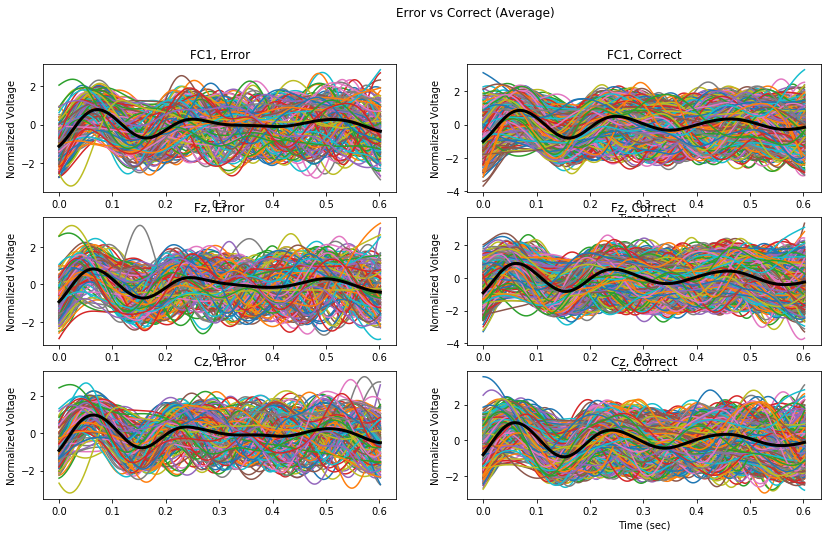

In [45]:
# Make time vector for epochs
time_epoch = np.linspace(0,len(epochs[0]['Fz'])/fs,len(epochs[0]['Fz']))

# Get average timeseries waveform for error and correct
channelsOfInt = ['FC1','FC1','Fz','Fz','Cz','Cz']
trials = [error_trials, correct_trials, error_trials, correct_trials, error_trials, correct_trials]

# Set up for plotting
Nr = 3
Nc = 2
fig, axes = plt.subplots(Nr, Nc, figsize=(16,8))
fig.suptitle('Error vs Correct (Average)')
i = 0
j = 1

for ax in axes.flat:
    chanOfInt = channelsOfInt[i]
    tmp_to_avg = list()

    for trial in trials[i]:
        tmp1 = epochs[trial][chanOfInt].values
        tmp = (tmp1 - np.mean(tmp1))/np.std(tmp1)
        #tmp = epochs_filt[trial][chanOfInt].values

        tmp_to_avg.append(tmp)
        ax.plot(time_epoch, tmp)

    # Plot the average in bold black
    ax.plot(time_epoch, np.mean(tmp_to_avg,0), linewidth=3, color='k')

    if j%2 == 0:
        ax.set_xlabel('Time (sec)')
        ax.set_title(channelsOfInt[i] + ', Correct')
    else:
        ax.set_title(channelsOfInt[i] + ', Error')
    ax.set_ylabel('Normalized Voltage')
    i += 1
    j += 1

fig.subplots_adjust(right=0.8)
fig.show()

In [46]:
channels

Index(['F3', 'Fz', 'F4', 'FC1', 'C3', 'Cz', 'C4', 'Pz'], dtype='object')

Plot the average waveforms (template)

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\matplotlib\figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


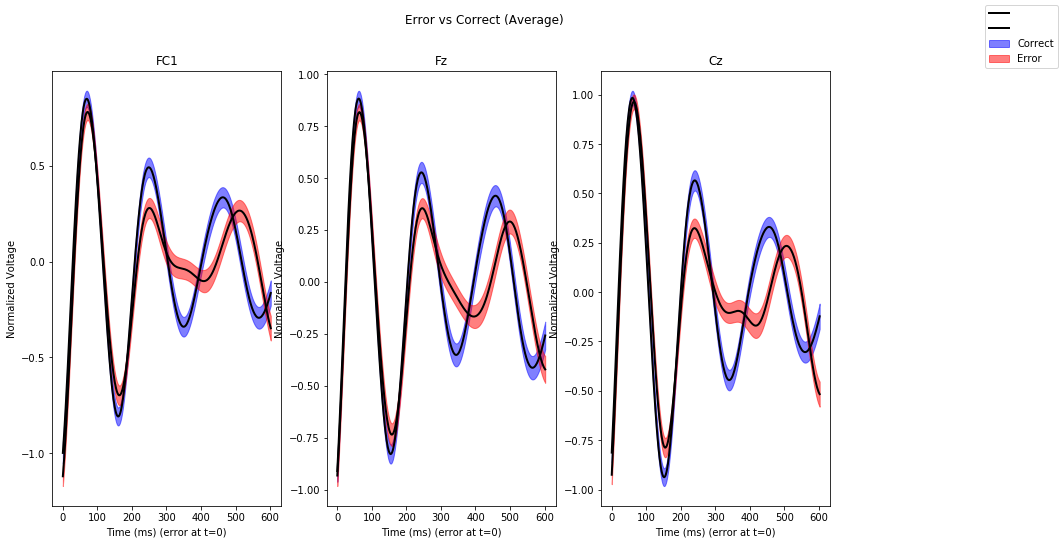

In [47]:
# Make time vector for epochs
time_epoch = np.linspace(0,len(epochs[0]['Fz'])/fs,len(epochs[0]['Fz']))*1000

# Get average timeseries waveform for error and correct
channelsOfInt = ['FC1','FC1','Fz','Fz','Cz','Cz']
trials = [correct_trials, error_trials, correct_trials, error_trials, correct_trials, error_trials]
plot_color = ['b','r','b','r','b','r']

# Set up for plotting
Nr = 1
Nc = 3
fig, axes = plt.subplots(Nr, Nc, figsize=(16,8))
fig.suptitle('Error vs Correct (Average)')
i = 0

for ax in axes.flat:
    chanOfInt = channelsOfInt[i]
    
    for ii in range(0,2):
        df = 1
        tmp_to_avg = list()

        for trial in trials[i]:
            tmp1 = epochs[trial][chanOfInt].values
            tmp = (tmp1 - np.mean(tmp1))/np.std(tmp1)
            #tmp = epochs_filt[trial][chanOfInt].values

            tmp_to_avg.append(tmp)

        # Plot the average in bold black
        mean_line = np.mean(tmp_to_avg,0)
        ax.plot(time_epoch, mean_line, linewidth=2, color='k')

        # Plot standard error (std / sqrt(Nsamples))
        plot_error = np.std(tmp_to_avg,0)/np.sqrt(len(tmp))
        ax.fill_between(time_epoch, mean_line + plot_error, mean_line - plot_error, color=plot_color[i],alpha=0.5)

        
        ax.set_xlabel('Time (ms) (error at t=0)')
        ax.set_title(channelsOfInt[i])
        ax.set_ylabel('Normalized Voltage')
        i += 1

fig.subplots_adjust(right=0.8)
fig.legend(['','','Correct','Error'])
fig.show()

Even though this looks promising, the error signals may seem more prominent because there was a smaller amount of data to average.

## Save the error and correct templates
Save the template waveforms we generated above by taking the average response after all erroneous movements (red) and all correct movements (blue)

In [48]:
# Get average timeseries waveform for error and correct
channelsOfInt = channels
error_template = dict()
correct_template = dict()

for chanOfInt in channelsOfInt:
    tmp_to_avg_error = list()
    tmp_to_avg_correct = list()

    for trial in error_trials:
        tmp1 = epochs[trial][chanOfInt].values
        tmp = (tmp1 - np.mean(tmp1))/np.std(tmp1)
        #tmp = epochs_filt[trial][chanOfInt].values

        tmp_to_avg_error.append(tmp)
        
    for trial in correct_trials:
        tmp1 = epochs[trial][chanOfInt].values
        tmp = (tmp1 - np.mean(tmp1))/np.std(tmp1)
        #tmp = epochs_filt[trial][chanOfInt].values

        tmp_to_avg_correct.append(tmp)

    # Plot the average in bold black
    error_template[chanOfInt] = np.mean(tmp_to_avg_error,0)
    correct_template[chanOfInt] = np.mean(tmp_to_avg_correct,0)

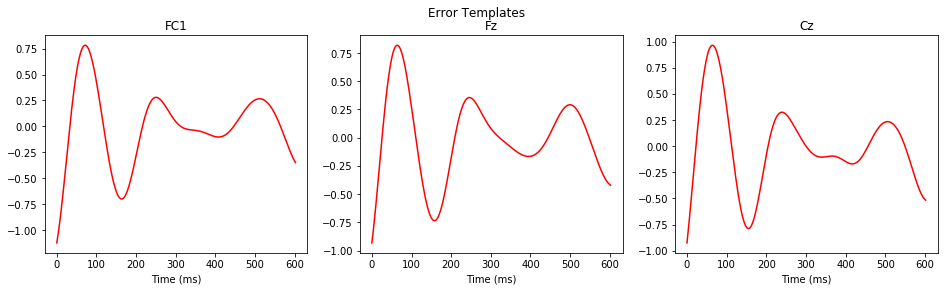

In [49]:
# Double check that they look correct
plt.figure(figsize=(16,4))
plt.suptitle('Error Templates')
plt.subplot(131), plt.plot(time_epoch,error_template['FC1'],'r'), plt.title('FC1'), plt.xlabel('Time (ms)')
plt.subplot(132), plt.plot(time_epoch,error_template['Fz'],'r'), plt.title('Fz'), plt.xlabel('Time (ms)')
plt.subplot(133), plt.plot(time_epoch,error_template['Cz'],'r'), plt.title('Cz'), plt.xlabel('Time (ms)')
plt.show()

In [50]:
channels

Index(['F3', 'Fz', 'F4', 'FC1', 'C3', 'Cz', 'C4', 'Pz'], dtype='object')

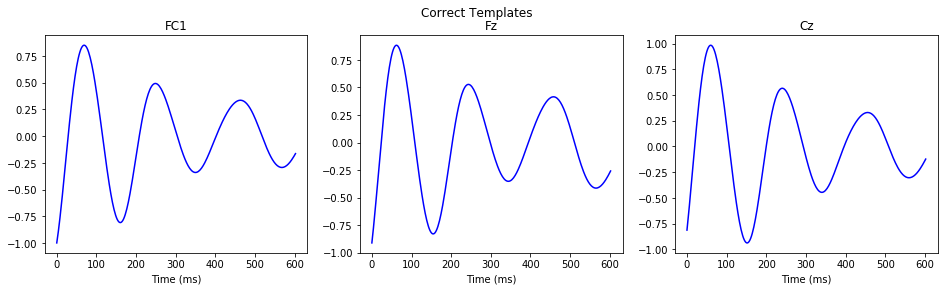

In [51]:
# Double check that they look correct
plt.figure(figsize=(16,4))
plt.suptitle('Correct Templates')
plt.subplot(131), plt.plot(time_epoch,correct_template['FC1'],'b'), plt.title('FC1'), plt.xlabel('Time (ms)')
plt.subplot(132), plt.plot(time_epoch,correct_template['Fz'],'b'), plt.title('Fz'), plt.xlabel('Time (ms)')
plt.subplot(133), plt.plot(time_epoch,correct_template['Cz'],'b'), plt.title('Cz'), plt.xlabel('Time (ms)')
plt.show()

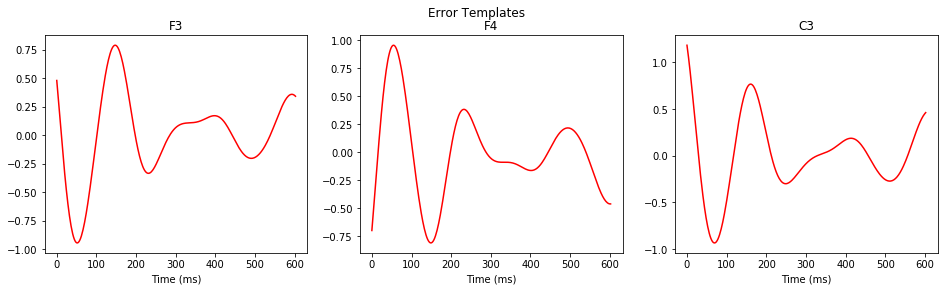

In [52]:
# Double check that they look correct
plt.figure(figsize=(16,4))
plt.suptitle('Error Templates')
plt.subplot(131), plt.plot(time_epoch,error_template['F3'],'r'), plt.title('F3'), plt.xlabel('Time (ms)')
plt.subplot(132), plt.plot(time_epoch,error_template['F4'],'r'), plt.title('F4'), plt.xlabel('Time (ms)')
plt.subplot(133), plt.plot(time_epoch,error_template['C3'],'r'), plt.title('C3'), plt.xlabel('Time (ms)')
plt.show()

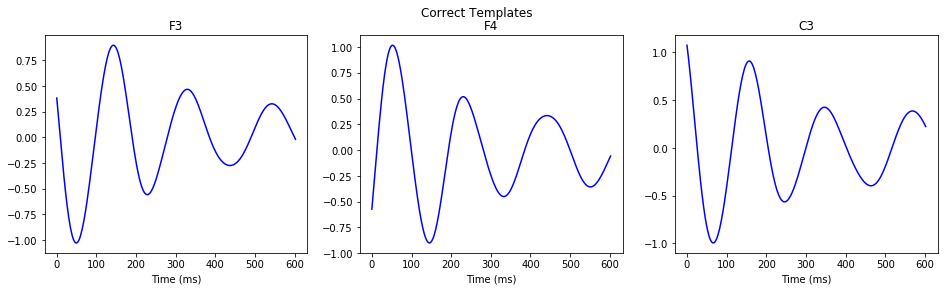

In [53]:
# Double check that they look correct
plt.figure(figsize=(16,4))
plt.suptitle('Correct Templates')
plt.subplot(131), plt.plot(time_epoch,correct_template['F3'],'b'), plt.title('F3'), plt.xlabel('Time (ms)')
plt.subplot(132), plt.plot(time_epoch,correct_template['F4'],'b'), plt.title('F4'), plt.xlabel('Time (ms)')
plt.subplot(133), plt.plot(time_epoch,correct_template['C3'],'b'), plt.title('C3'), plt.xlabel('Time (ms)')
plt.show()

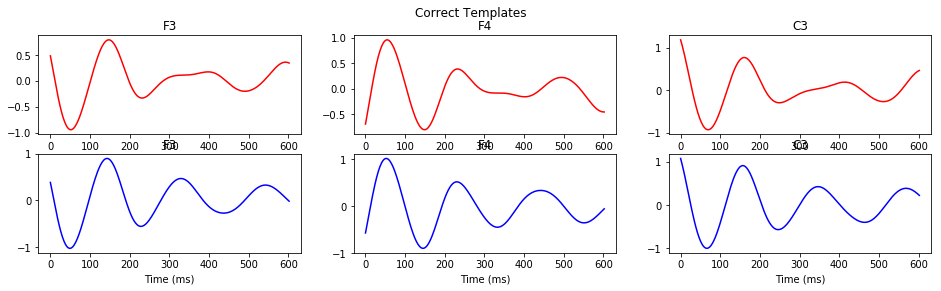

In [54]:
# Double check that they look correct
plt.figure(figsize=(16,4))
plt.suptitle('Error Templates')
plt.subplot(231), plt.plot(time_epoch,error_template['F3'],'r'), plt.title('F3'), plt.xlabel('Time (ms)')
plt.subplot(232), plt.plot(time_epoch,error_template['F4'],'r'), plt.title('F4'), plt.xlabel('Time (ms)')
plt.subplot(233), plt.plot(time_epoch,error_template['C3'],'r'), plt.title('C3'), plt.xlabel('Time (ms)')

# Double check that they look correct

plt.suptitle('Correct Templates')
plt.subplot(234), plt.plot(time_epoch,correct_template['F3'],'b'), plt.title('F3'), plt.xlabel('Time (ms)')
plt.subplot(235), plt.plot(time_epoch,correct_template['F4'],'b'), plt.title('F4'), plt.xlabel('Time (ms)')
plt.subplot(236), plt.plot(time_epoch,correct_template['C3'],'b'), plt.title('C3'), plt.xlabel('Time (ms)')
plt.show()

## Test template projection
Test using our template waveform on error and correct epochs. Perform this testing not only on epochs from this data set, but from the error screening run 2 as well.

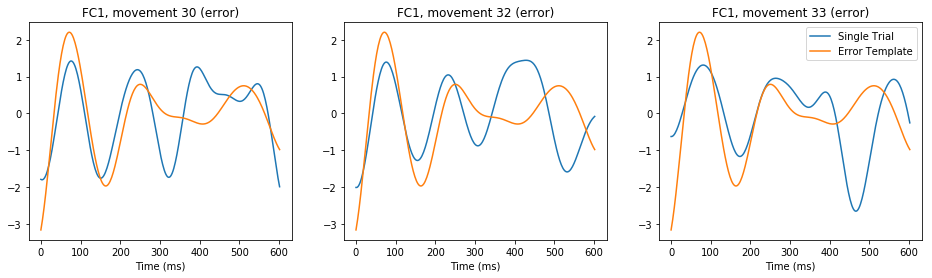

In [56]:
# Double check that they look correct
chanOfInt = 'FC1'
plt.figure(figsize=(16,4))

cnt = 1
for i in range(4,7):
    plt.subplot(130 + cnt)
    # Normalize 
    tmp = epochs[error_trials[i]][chanOfInt]
    tmp_norm = (tmp - np.mean(tmp))/np.std(tmp)
    plt.plot(time_epoch,tmp_norm)
    # Plot normalized template over
    tmp = error_template[chanOfInt]
    tmp_norm = (tmp - np.mean(tmp))/np.std(tmp)
    plt.plot(time_epoch, tmp_norm)
    plt.title(chanOfInt + ', movement ' + str(error_trials[i]) + ' (error)')
    plt.xlabel('Time (ms)')
    cnt += 1

plt.legend(['Single Trial', 'Error Template'])
plt.show()

Let's also plot the template error waveform on correct movements as well. Ideally, the waveform would fit really well for only observations after error movments and not for observations after correct movements.

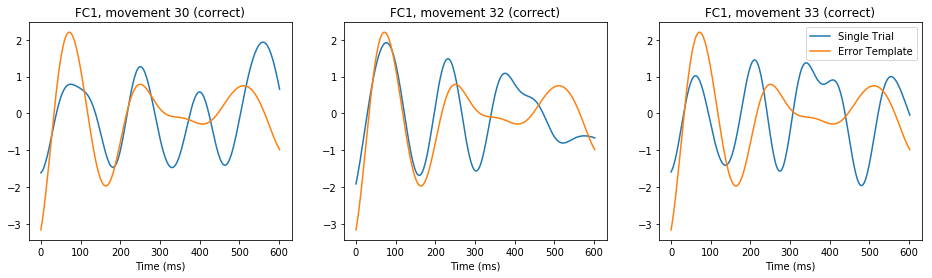

In [57]:
chanOfInt = 'FC1'
plt.figure(figsize=(16,4))

cnt = 1
for i in range(4,7):
    plt.subplot(130 + cnt)
    # Normalize 
    tmp = epochs[correct_trials[i]][chanOfInt]
    tmp_norm = (tmp - np.mean(tmp))/np.std(tmp)
    plt.plot(time_epoch,tmp_norm)
    # Plot normalized template over
    tmp = error_template[chanOfInt]
    tmp_norm = (tmp - np.mean(tmp))/np.std(tmp)
    plt.plot(time_epoch, tmp_norm)
    plt.title(chanOfInt + ', movement ' + str(error_trials[i]) + ' (correct)')
    plt.xlabel('Time (ms)')
    cnt += 1

plt.legend(['Single Trial', 'Error Template'])
plt.show()

### Convolution
For double checking meaning of convlution for signal comparison, see the analogy to DATA and PATTERN in https://dsp.stackexchange.com/questions/4723/what-is-the-physical-meaning-of-the-convolution-of-two-signals

In [58]:
i = 4
chanOfInt = 'FC1'
tmp = epochs[error_trials[i]][chanOfInt]
tmp_norm = (tmp - np.mean(tmp))/np.std(tmp)
a = tmp_norm

tmp = error_template[chanOfInt]
tmp_norm = (tmp - np.mean(tmp))/np.std(tmp)
b = tmp_norm
c_same = np.convolve(a,b,'same')
c_full = np.convolve(a,b,'full')

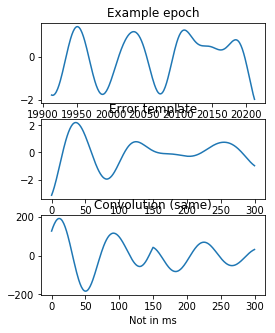

In [59]:
# Plot
plt.figure(figsize=(4,5))
plt.subplot(311)
plt.plot(a)
plt.title('Example epoch')
plt.subplot(312)
plt.plot(b)
plt.title('Error template')
plt.xlabel('Samples')
plt.subplot(313)
plt.plot(c_same)
plt.title('Convolution (same)')
plt.xlabel('Not in ms')
plt.show()

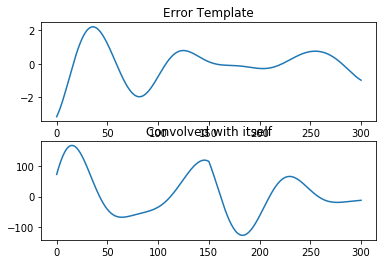

In [60]:
# One method could be 
plt.figure()
plt.subplot(211)
plt.plot(b)
plt.title('Error Template')
plt.subplot(212)
plt.plot(np.convolve(b,b,'same'))
plt.title('Convolved with itself')
plt.show()

Okay try now

In [61]:
# template_projection[chanOfInt] will have two columns
# col 1: how well the trial signal matches with the error signal template
# col 2: how well the trial signal matches with the correct signal template
projections_all = dict()
channelsToUse = error_template.keys()

for chanOfInt in channelsToUse:
    projections = np.zeros([2, num_of_trials])
    for trial in range(0, num_of_trials):
        # Individual epoch (normalized)
        tmp = epochs[trial][chanOfInt]
        tmp_norm = (tmp - np.mean(tmp))/np.std(tmp)
        a = tmp_norm

        # Template waveform for error (normalized)
        tmp = error_template[chanOfInt]
        tmp_norm = (tmp - np.mean(tmp))/np.std(tmp)
        b = tmp_norm
        
        # Template waveform for correct (normalized)|
        tmp = correct_template[chanOfInt]
        tmp_norm = (tmp - np.mean(tmp))/np.std(tmp)
        c = tmp_norm
        
        # Store sum of convolutions
        projections[0][trial] = np.sum(np.convolve(a,b,'same'))
        projections[1][trial] = np.sum(np.convolve(a,c,'same'))

    projections_all[chanOfInt] = projections

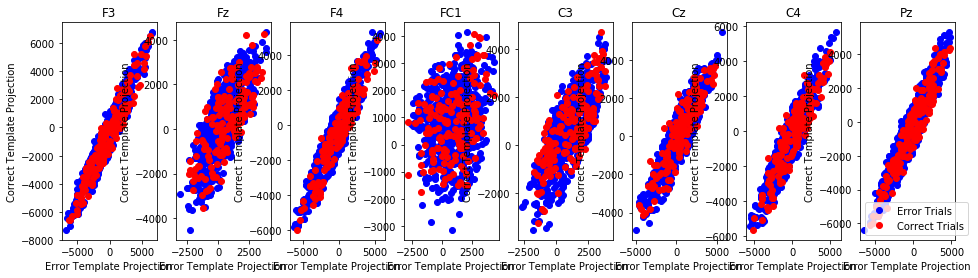

In [62]:
channelsToUse = error_template.keys()
plt.figure(figsize=(16,4))

cnt = 1
for chanOfInt in channelsToUse:
    plt.subplot(180 + cnt)
    tmp = projections_all[chanOfInt]
    plt.plot(tmp[0][correct_trials], tmp[1][correct_trials], 'bo')
    plt.plot(tmp[0][error_trials], tmp[1][error_trials], 'ro')
    
    plt.title(chanOfInt)
    plt.xlabel('Error Template Projection')
    plt.ylabel('Correct Template Projection')
    cnt += 1

plt.legend(['Error Trials','Correct Trials'])
plt.show()

The sums of the convolutions seem to be always going to zero... so let's only look at key points in the template. AKA our expected ErrP timing? Should be about 100-200 ms and 400-500 ms in my waveform.

In [63]:
# template_projection[chanOfInt] will have two columns
# col 1: how well the trial signal matches with the error signal template
# col 2: how well the trial signal matches with the correct signal template
projections_all = dict()
channelsToUse = error_template.keys()

for chanOfInt in channelsToUse:
    projections = np.zeros([2, num_of_trials])
    for trial in range(0, num_of_trials):
        # Individual epoch (normalized)
        tmp = epochs[trial][chanOfInt]
        tmp_norm = (tmp - np.mean(tmp))/np.std(tmp)
        a = tmp_norm

        # Template waveform for error (normalized)
        tmp = error_template[chanOfInt]
        tmp_norm = (tmp - np.mean(tmp))/np.std(tmp)
        b = tmp_norm
        
        # Template waveform for correct (normalized)
        tmp = correct_template[chanOfInt]
        tmp_norm = (tmp - np.mean(tmp))/np.std(tmp)
        c = tmp_norm
        
        # Store sum of convolutions
        tmp = np.convolve(a,b,'same')
        projections[0][trial] = np.sum(tmp[:100])
        tmp = np.convolve(a,c,'same')
        projections[1][trial] = np.sum(tmp[:100])

    projections_all[chanOfInt] = projections

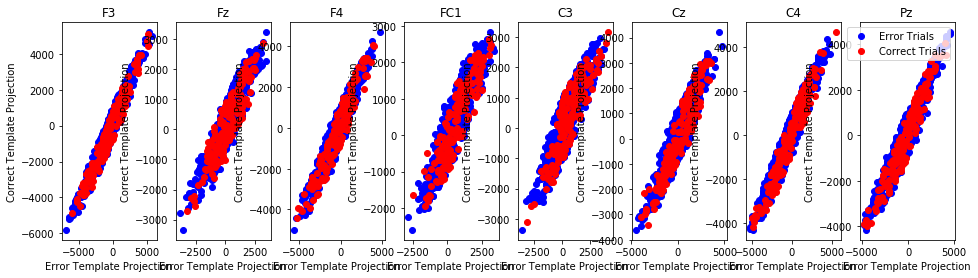

In [64]:
channelsToUse = error_template.keys()
plt.figure(figsize=(16,4))

cnt = 1
for chanOfInt in channelsToUse:
    plt.subplot(180 + cnt)
    tmp = projections_all[chanOfInt]
    plt.plot(tmp[0][correct_trials], tmp[1][correct_trials], 'bo')
    plt.plot(tmp[0][error_trials], tmp[1][error_trials], 'ro')
    
    plt.title(chanOfInt)
    plt.xlabel('Error Template Projection')
    plt.ylabel('Correct Template Projection')
    cnt += 1

plt.legend(['Error Trials','Correct Trials'])
plt.show()

## Normalizing baseline
Let's also try normalizing the epochs to baseline instead of just normalizing via subtracting the mean and dividing by the standard deviation of the epoch itself.

In [65]:
epochs_norm = []

for trial in range(0,len(t_trial_start)):
    t_start = np.round((t_trial_start[trial] - 0 ) * fs)
    t_end = np.round((t_trial_start[trial] + 0.600) * fs)
    
    # Baseline
    tb_start = np.round((t_trial_start[trial] - 0.700 ) * fs)
    tb_end = np.round((t_trial_start[trial] - 0.100) * fs)
    baseline = EEGdata.loc[tb_start:tb_end][channels]
    
    # Store epoch
    tmp = (EEGdata.loc[t_start:t_end][channels] - np.mean(baseline))/np.std(baseline)
    epochs_norm.append(tmp)

Save baseline normalized error and correct response templates

In [66]:
# Get average timeseries waveform for error and correct
channelsOfInt = channels
error_template = dict()
correct_template = dict()

for chanOfInt in channelsOfInt:
    tmp_to_avg_error = list()
    tmp_to_avg_correct = list()

    for trial in error_trials:
        tmp = epochs_norm[trial][chanOfInt].values
        tmp_to_avg_error.append(tmp)
        
    for trial in correct_trials:
        tmp = epochs_norm[trial][chanOfInt].values
        tmp_to_avg_correct.append(tmp)

    # Plot the average in bold black
    error_template[chanOfInt] = np.mean(tmp_to_avg_error,0)
    correct_template[chanOfInt] = np.mean(tmp_to_avg_correct,0)

Plot to see

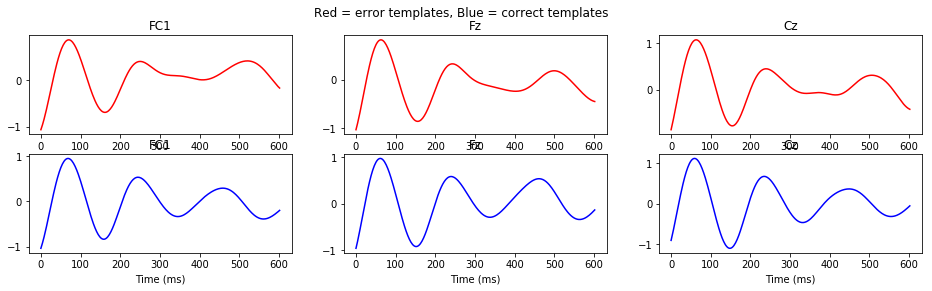

In [67]:
# Double check that they look correct
plt.figure(figsize=(16,4))
plt.suptitle('Error Templates')
plt.subplot(231), plt.plot(time_epoch,error_template['FC1'],'r'), plt.title('FC1'), plt.xlabel('Time (ms)')
plt.subplot(232), plt.plot(time_epoch,error_template['Fz'],'r'), plt.title('Fz'), plt.xlabel('Time (ms)')
plt.subplot(233), plt.plot(time_epoch,error_template['Cz'],'r'), plt.title('Cz'), plt.xlabel('Time (ms)')

# Double check that they look correct

plt.suptitle('Red = error templates, Blue = correct templates')
plt.subplot(234), plt.plot(time_epoch,correct_template['FC1'],'b'), plt.title('FC1'), plt.xlabel('Time (ms)')
plt.subplot(235), plt.plot(time_epoch,correct_template['Fz'],'b'), plt.title('Fz'), plt.xlabel('Time (ms)')
plt.subplot(236), plt.plot(time_epoch,correct_template['Cz'],'b'), plt.title('Cz'), plt.xlabel('Time (ms)')
plt.show()

Check how they look with baseline normalized epochs

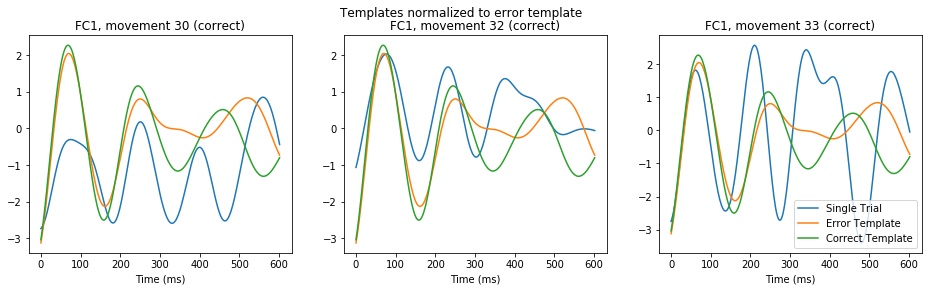

In [68]:
chanOfInt = 'FC1'
plt.figure(figsize=(16,4))

cnt = 1
for i in range(4,7):
    plt.subplot(130 + cnt)
    # Normalize 
    a = epochs_norm[correct_trials[i]][chanOfInt]
    plt.plot(time_epoch,a)
    # Plot normalized template over (error)
    b = error_template[chanOfInt]
    tmp_norm = (b - np.mean(b))/np.std(b)
    plt.plot(time_epoch, tmp_norm)
    # Plot normalized template over (correct)
    c = correct_template[chanOfInt]
    tmp_norm = (c - np.mean(b))/np.std(b)
    plt.plot(time_epoch, tmp_norm)
    plt.title(chanOfInt + ', movement ' + str(error_trials[i]) + ' (correct)')
    plt.xlabel('Time (ms)')
    cnt += 1

plt.legend(['Single Trial', 'Error Template','Correct Template'])
plt.suptitle('Templates normalized to error template')
plt.show()

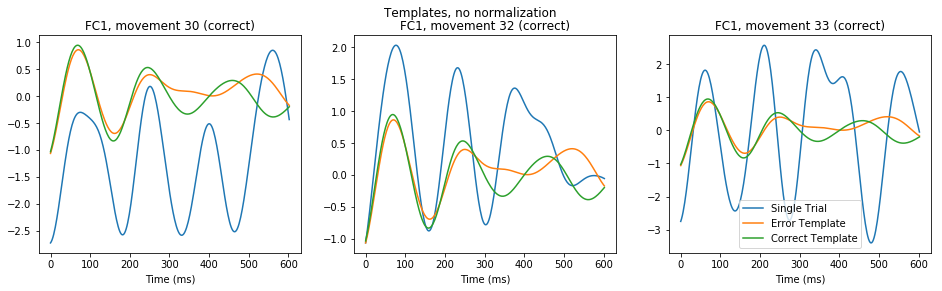

In [69]:
chanOfInt = 'FC1'
plt.figure(figsize=(16,4))

cnt = 1
for i in range(4,7):
    plt.subplot(130 + cnt)
    # Normalize 
    a = epochs_norm[correct_trials[i]][chanOfInt]
    plt.plot(time_epoch,a)
    # Plot normalized template over (error)
    b = error_template[chanOfInt]
    tmp_norm = (b - np.mean(a))/np.std(a)
    plt.plot(time_epoch, b)
    # Plot normalized template over (correct)
    c = correct_template[chanOfInt]
    tmp_norm = (c - np.mean(a))/np.std(a)
    plt.plot(time_epoch, c)
    plt.title(chanOfInt + ', movement ' + str(error_trials[i]) + ' (correct)')
    plt.xlabel('Time (ms)')
    cnt += 1

plt.legend(['Single Trial', 'Error Template','Correct Template'])
plt.suptitle('Templates, no normalization')
plt.show()

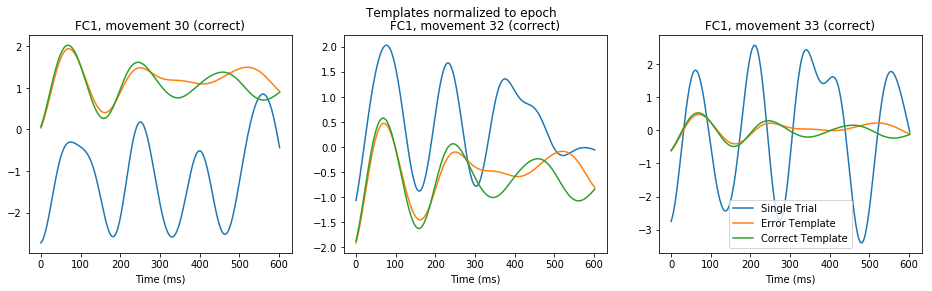

In [70]:
chanOfInt = 'FC1'
plt.figure(figsize=(16,4))

cnt = 1
for i in range(4,7):
    plt.subplot(130 + cnt)
    # Normalize 
    a = epochs_norm[correct_trials[i]][chanOfInt]
    plt.plot(time_epoch,a)
    # Plot normalized template over (error)
    b = error_template[chanOfInt]
    tmp_norm = (b - np.mean(a))/np.std(a)
    plt.plot(time_epoch, tmp_norm)
    # Plot normalized template over (correct)
    c = correct_template[chanOfInt]
    tmp_norm = (c - np.mean(a))/np.std(a)
    plt.plot(time_epoch, tmp_norm)
    plt.title(chanOfInt + ', movement ' + str(error_trials[i]) + ' (correct)')
    plt.xlabel('Time (ms)')
    cnt += 1

plt.legend(['Single Trial', 'Error Template','Correct Template'])
plt.suptitle('Templates normalized to epoch')
plt.show()

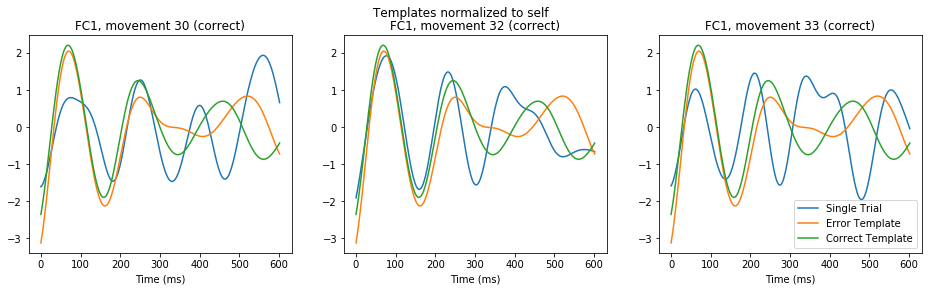

In [71]:
chanOfInt = 'FC1'
plt.figure(figsize=(16,4))

cnt = 1
for i in range(4,7):
    plt.subplot(130 + cnt)
    # Normalize 
    tmp = epochs_norm[correct_trials[i]][chanOfInt]
    tmp_norm = (tmp - np.mean(tmp))/np.std(tmp)
    plt.plot(time_epoch,tmp_norm)
    # Plot normalized template over (error)
    tmp = error_template[chanOfInt]
    tmp_norm = (tmp - np.mean(tmp))/np.std(tmp)
    plt.plot(time_epoch, tmp_norm)
    # Plot normalized template over (correct)
    tmp = correct_template[chanOfInt]
    tmp_norm = (tmp - np.mean(tmp))/np.std(tmp)
    plt.plot(time_epoch, tmp_norm)
    plt.title(chanOfInt + ', movement ' + str(error_trials[i]) + ' (correct)')
    plt.xlabel('Time (ms)')
    cnt += 1

plt.legend(['Single Trial', 'Error Template','Correct Template'])
plt.suptitle('Templates normalized to self')
plt.show()

Projections

In [72]:
# template_projection[chanOfInt] will have two columns
# col 1: how well the trial signal matches with the error signal template
# col 2: how well the trial signal matches with the correct signal template
projections_all = dict()
channelsToUse = error_template.keys()

for chanOfInt in channelsToUse:
    projections = np.zeros([2, num_of_trials])
    for trial in range(0, num_of_trials):
        # Individual epoch (normalized)
        tmp = epochs_norm[trial][chanOfInt]
        a = tmp

        # Template waveform for error (normalized)
        tmp = error_template[chanOfInt]
        tmp_norm = (tmp - np.mean(tmp))/np.std(tmp)
        b = tmp_norm
        
        # Template waveform for correct (normalized)
        tmp = correct_template[chanOfInt]
        tmp_norm = (tmp - np.mean(tmp))/np.std(tmp)
        c = tmp_norm
        
        
        # Store sum of convolutions
        projections[0][trial] = np.sum(np.convolve(a,b,'same'))
        projections[1][trial] = np.sum(np.convolve(a,c,'same'))
        """
        projections[0][trial] = np.dot(a,b)
        projections[1][trial] = np.dot(a,c)
        """

    projections_all[chanOfInt] = projections

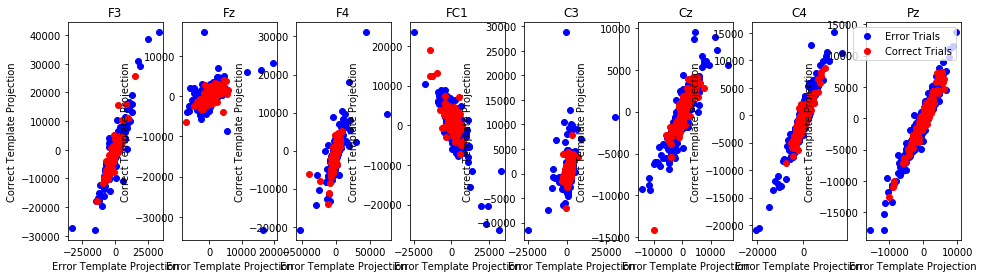

In [73]:
channelsToUse = error_template.keys()
plt.figure(figsize=(16,4))

cnt = 1
for chanOfInt in channelsToUse:
    plt.subplot(180 + cnt)
    tmp = projections_all[chanOfInt]
    plt.plot(tmp[0][correct_trials], tmp[1][correct_trials], 'bo')
    plt.plot(tmp[0][error_trials], tmp[1][error_trials], 'ro')
    
    plt.title(chanOfInt)
    plt.xlabel('Error Template Projection')
    plt.ylabel('Correct Template Projection')
    cnt += 1

plt.legend(['Error Trials','Correct Trials'])
plt.show()

Also try just taking particular part of template

In [74]:
# template_projection[chanOfInt] will have two columns
# col 1: how well the trial signal matches with the error signal template
# col 2: how well the trial signal matches with the correct signal template
projections_all = dict()
channelsToUse = error_template.keys()

for chanOfInt in channelsToUse:
    projections = np.zeros([2, num_of_trials])
    for trial in range(0, num_of_trials):
        # Individual epoch (normalized)
        tmp = epochs_norm[trial][chanOfInt]
        a = tmp

        # Template waveform for error (normalized)
        tmp = error_template[chanOfInt]
        tmp_norm = (tmp - np.mean(tmp))/np.std(tmp)
        b = tmp_norm
        
        # Template waveform for correct (normalized)
        tmp = correct_template[chanOfInt]
        tmp_norm = (tmp - np.mean(tmp))/np.std(tmp)
        c = tmp_norm
        
        # Store sum of convolutions
        
        tmp = np.convolve(a,b,'same')
        projections[0][trial] = np.sum(tmp[50:100]) + np.sum(tmp[200:250])
        tmp = np.convolve(a,c,'same')
        projections[1][trial] = np.sum(tmp[50:100]) + np.sum(tmp[200:250])
        """
        projections[0][trial] = np.dot(a[50:100],b[50:100]) + np.dot(a[200:250],b[200:250])
        projections[1][trial] = np.dot(a[50:100],c[50:100]) + np.dot(a[200:250],c[200:250])
        """

    projections_all[chanOfInt] = projections

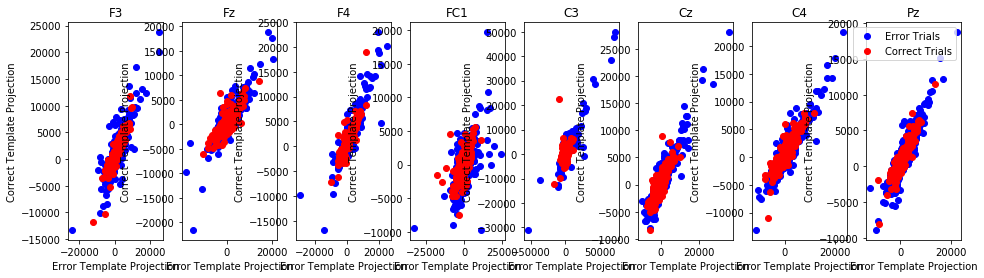

In [75]:
channelsToUse = error_template.keys()
plt.figure(figsize=(16,4))

cnt = 1
for chanOfInt in channelsToUse:
    plt.subplot(180 + cnt)
    tmp = projections_all[chanOfInt]
    plt.plot(tmp[0][correct_trials], tmp[1][correct_trials], 'bo')
    plt.plot(tmp[0][error_trials], tmp[1][error_trials], 'ro')
    
    plt.title(chanOfInt)
    plt.xlabel('Error Template Projection')
    plt.ylabel('Correct Template Projection')
    cnt += 1

plt.legend(['Error Trials','Correct Trials'])
plt.show()

Hm... this paper said baseline wasn't necessary / didn't really help in their single trial classification https://ieeexplore.ieee.org/document/7591303 "For the baseline correction, although it is highly recommended in the ERP analysis of performance monitoring [1], our current results using both temporal and frequency features indicated that it was unnecessary in terms of single-trial classification of error and correct responses."

Their study also found that features in the time domain tended to do better than frequency space features. This seems to typically be the case for error analysis.

## Frequency Analysis
Let's also try investigating delta and theta power
https://ieeexplore.ieee.org/document/7591303

In [76]:
from scipy.fftpack import fft, ifft
from scipy import signal

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\spectral.py:1773: UserWarning: nperseg = 256 is greater than input length  = 61, using nperseg = 61
  .format(nper

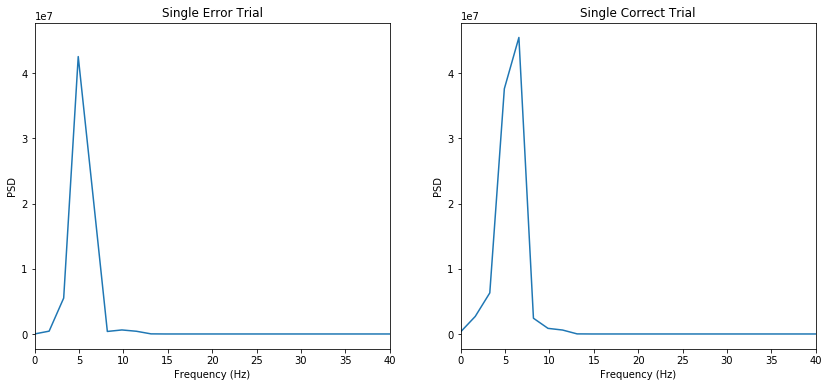

In [77]:
i = 10
chanOfInt = 'FC1'
ds_f = 5 # downsample factor
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, sharey=ax1)


f, Pxx_den = signal.welch(signal.decimate(epochs[error_trials[i]][chanOfInt],ds_f), fs/ds_f, scaling='spectrum')
ax1.plot(f, Pxx_den)
ax1.set_xlim([0, 40])
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('PSD')
ax1.set_title('Single Error Trial')

f, Pxx_den = signal.welch(signal.decimate(epochs[correct_trials[i]][chanOfInt],ds_f), fs/ds_f, scaling='spectrum')
ax2.plot(f, Pxx_den)
ax2.set_xlim([0, 40])
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('PSD')
ax2.set_title('Single Correct Trial')

plt.show()

Huh... power might be higher in delta (less than 5 Hz) consistently for correct trials over error trials

In [78]:
# Get the summed delta power for each trial
channelsToUse = error_template.keys()
delta_power = dict.fromkeys(channelsToUse)
theta_power = dict.fromkeys(channelsToUse)
ds_f = 1 # downsampling factor

for chanOfInt in channelsToUse:
    tmp_delta = list()
    tmp_theta = list()
    
    for trial in range(0, num_of_trials):
        f, Pxx_den = signal.welch(signal.decimate(epochs_norm[trial][chanOfInt],ds_f), fs/ds_f, scaling='spectrum')
        delta_idx = np.where(np.round(f) <= 4)
        tmp_delta.append(np.sum(Pxx_den[delta_idx]))
        
        theta_idx = np.where(np.logical_and(np.round(f) > 4, np.round(f) <= 7))
        tmp_theta.append(np.sum(Pxx_den[theta_idx]))
        
    delta_power[chanOfInt] = tmp_delta
    theta_power[chanOfInt] = tmp_theta

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


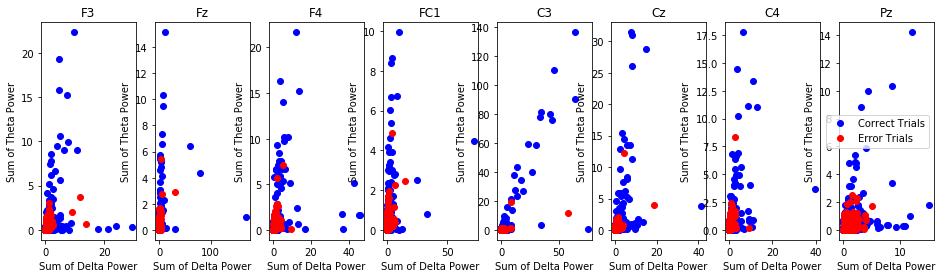

In [79]:
channelsToUse = error_template.keys()
plt.figure(figsize=(16,4))

cnt = 1
for chanOfInt in channelsToUse:
    plt.subplot(180 + cnt)
    tmp_delta = np.asarray(delta_power[chanOfInt])
    tmp_theta = np.asarray(theta_power[chanOfInt])
    plt.plot(tmp_delta[correct_trials], tmp_theta[correct_trials], 'bo')
    plt.plot(tmp_delta[error_trials], tmp_theta[error_trials], 'ro')
    
    plt.title(chanOfInt)
    plt.xlabel('Sum of Delta Power')
    plt.ylabel('Sum of Theta Power')
    cnt += 1

plt.legend(['Correct Trials','Error Trials'])
plt.show()

## Other methods
Let's try other single trial classification methods described in the literature besides Kai's template projection (was not used for error)
https://ieeexplore.ieee.org/document/7591303

# Notes
Meeting with Patrick
- Try to run error detection on your ICs instead
- automatic selection of which IC to use based on a template?
- classifying state transitions vs not transition (transition possibly brought about error potential?) <-- might be messy with MI though (since MI might also be considered state changes)

## Classification
Let's try classifying anyways

In [80]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

### Classify on frequency space features
Create a features matrix X that contains the delta and theta power for each channel

In [81]:
# Get the summed delta power for each trial
channelsToUse = error_template.keys()
delta_power = dict.fromkeys(channelsToUse)
theta_power = dict.fromkeys(channelsToUse)
ds_f = 1 # downsampling factor

for chanOfInt in channelsToUse:
    tmp_delta = list()
    tmp_theta = list()
    
    for trial in range(0, num_of_trials):
        f, Pxx_den = signal.welch(signal.decimate(epochs_norm[trial][chanOfInt],ds_f), fs/ds_f, scaling='spectrum')
        delta_idx = np.where(np.round(f) <= 4)
        tmp_delta.append(np.sum(Pxx_den[delta_idx]))
        
        theta_idx = np.where(np.logical_and(np.round(f) > 4, np.round(f) <= 7))
        tmp_theta.append(np.sum(Pxx_den[theta_idx]))
        
    delta_power[chanOfInt] = tmp_delta
    theta_power[chanOfInt] = tmp_theta

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


In [82]:
# Get X
num_of_examples = len(delta_power['F3'])
num_of_features = len(delta_power.keys()) + len(theta_power.keys()) 
features = np.zeros([num_of_features, num_of_examples])

# Get all channels in one list to loop through
feature_channels = np.concatenate([np.asarray(list(delta_power.keys())),np.asarray(list(theta_power.keys()))])

for i in range(0, num_of_examples):
    for j in range(0, num_of_features//2):
        features[j, i] = delta_power[feature_channels[j]][i]
    for j in range(num_of_features//2, num_of_features):
        features[j, i] = theta_power[feature_channels[j]][i]

# Get y
trial_type = np.zeros([1, num_of_trials])

for i in error_trials:
    trial_type[0][i] = 1

trial_type = trial_type[0]

In [83]:
print('X: ' + str(np.shape(features)))
print('y: ' + str(np.shape(trial_type)))

X: (16, 758)
y: (758,)


Don't forget to account for imbalanced data https://github.com/vsmolyakov/experiments_with_python/blob/master/chp01/imbalanced_data.ipynb

In [84]:
from imblearn.over_sampling import SMOTE

In [85]:
# Fit a simple neural network (multilayer perceptron)
X = features.T
y = trial_type

# preprocess dataset, split into training and test part
X = StandardScaler().fit_transform(X)

# Resample to account for imbalance
method = SMOTE(kind='regular')
X, y = method.fit_sample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

# Determine model parameters
activations = ['relu','tanh']
alphas = np.logspace(-6, 3, 10)
solvers = ['lbfgs','sgd']
hyper_params = {"activation":activations, "alpha":alphas, "solver":solvers}
grid = GridSearchCV(MLPClassifier(learning_rate='constant', random_state=1), param_grid=hyper_params, cv=KFold(n_splits=5), verbose=True)
grid.fit(X_train, y_train)

# Fit the model
clf = grid.best_estimator_
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

print(grid.best_estimator_)
print('-----------')
print('score: ' + str(score))
print(confusion_matrix(y_test, clf.predict(X_test)))
print('-----------')

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
-----------
score: 0.8089887640449438
[[128  45]
 [ 23 160]]
-----------


### Classify on template projections
Create a features matrix X that contains the error template projection and correcte template projection values for all channels

In [86]:
# template_projection[chanOfInt] will have two columns
# col 1: how well the trial signal matches with the error signal template
# col 2: how well the trial signal matches with the correct signal template
projections_all = dict()
channelsToUse = error_template.keys()

for chanOfInt in channelsToUse:
    projections = np.zeros([2, num_of_trials])
    for trial in range(0, num_of_trials):
        # Individual epoch (normalized)
        tmp = epochs_norm[trial][chanOfInt]
        a = tmp

        # Template waveform for error (normalized)
        tmp0 = error_template[chanOfInt]
        tmp_norm = (tmp0 - np.mean(tmp0))/np.std(tmp0)
        b = tmp_norm
        
        # Template waveform for correct (normalized)
        tmp = correct_template[chanOfInt]
        tmp_norm = (tmp - np.mean(tmp0))/np.std(tmp0)
        c = tmp_norm
        
        # Store sum of convolutions
        
        projections[0][trial] = np.sum(np.convolve(a,b,'same'))
        projections[1][trial] = np.sum(np.convolve(a,c,'same'))
        
        """
        tmp = np.convolve(a,b,'same')
        projections[0][trial] = np.sum(tmp[50:100]) + np.sum(tmp[200:250])
        tmp = np.convolve(a,c,'same')
        projections[1][trial] = np.sum(tmp[50:100]) + np.sum(tmp[200:250])
        """
       
        """
        projections[0][trial] = np.dot(a[50:100],b[50:100]) + np.dot(a[200:250],b[200:250])
        projections[1][trial] = np.dot(a[50:100],c[50:100]) + np.dot(a[200:250],c[200:250])
        """

    projections_all[chanOfInt] = projections

Reformat to work nicely with classifier

In [87]:
# Get X
channels = list(projections_all.keys())
num_of_features = np.shape(projections_all['F3'])[0] * len(channels)
channels_full = list(projections_all.keys()) * 2
num_of_trials = np.shape(projections_all['F3'])[1]

features = np.zeros([num_of_features, num_of_trials])

for trial in range(0, num_of_trials):
    # Error trials are 0 to num_of_features//2, and correct trials are num_of_features//2 to num_of_features
    for feature in range(0, num_of_features):
        features[feature, trial] = projections_all[channels_full[feature]][0][trial]

# Get y
trial_type = np.zeros([1, num_of_trials])
for i in error_trials:
    trial_type[0][i] = 1

trial_type = trial_type[0]

Don't forget to account for imbalanced data https://github.com/vsmolyakov/experiments_with_python/blob/master/chp01/imbalanced_data.ipynb

In [88]:
from imblearn.over_sampling import SMOTE

In [89]:
# Fit a simple neural network (multilayer perceptron)
X = features.T
y = trial_type

# preprocess dataset, split into training and test part
X = StandardScaler().fit_transform(X)

# Resample to account for imbalance
method = SMOTE(kind='regular')
X, y = method.fit_sample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

# Determine model parameters
activations = ['relu','tanh']
alphas = np.logspace(-6, 3, 10)
solvers = ['lbfgs','sgd']
hyper_params = {"activation":activations, "alpha":alphas, "solver":solvers}
grid = GridSearchCV(MLPClassifier(learning_rate='constant', random_state=1), param_grid=hyper_params, cv=KFold(n_splits=5), verbose=True)
grid.fit(X_train, y_train)

# Fit the model
clf = grid.best_estimator_
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

print(grid.best_estimator_)
print('-----------')
print('score: ' + str(score))
print(confusion_matrix(y_test, clf.predict(X_test)))
print('-----------')

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: Convergen

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
-----------
score: 0.8033707865168539
[[129  41]
 [ 29 157]]
-----------
